In [1]:
from scipy import stats
import numpy as np

import ABC,ABC_Cross_Validation
from Models import LinearModel,ExponentialModel,SIRModel

# silence warnings about dodgy division
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Validation
Here I apply Leave-one-Out Cross-Validation to compare the variations on ABC methods I have applied

**Leave-one-Out Cross-Validation**

Cross-Validation allows us to compare the performance of different machine learning methods.

Leave-one-Out Cross-Validation involves
<ol>
    <li>Selecting one element $(x,y)$ from the training set ($(x_obs,y_obs)$).</li>
    <li>Training the model using the whole training set except $(x,y)$.</li>
    <li>Evaluating the models prediction for $(x,y)$. (e.g. RMSE)</li>
    <li>Repeating 1.-3. leaving a different data-point out each time.</li>
    <li>Choose model with the lowest total error.</li>
</ol>

**AIC Value**

$$ AIC=2k-\ln(\hat{L}) $$ where $\hat{L}$ is the maximum value of the likelihood function.

**Table of Contents**
 * [Linear Model](#Linear-Model)
     * [ABC-Rejection](#linear-rejection)
     * [ABC-MCMC](#linear-mcmc)
     * [ABC-SMC](#linear-smc)
     * [Adaptive ABC-SMC](#linear-adaptive-smc)
 * [Exponential Model](#Exponential-Model)
     * [ABC-Rejection](#exponential-rejection)
     * [ABC-MCMC](#exponential-mcmc)
     * [ABC-SMC](#exponential-smc)
     * [Adaptive ABC-SMC](#exponential-adaptive-smc)
 * [SIR Model](#SIR-Model)
     * [ABC-Rejection](#sir-rejection)
     * [ABC-MCMC](#sir-mcmc)
     * [ABC-SMC](#sir-smc)
     * [Adaptive ABC-SMC](#sir-adaptive-smc)
 * [Summary Statistic Selection Methods](#Summary-Statistic-Selection-Methods)
     * [Semi-Auto Rejection ABC](#Semi-Automatic-ABC)
 * [Results](#Results)

## Linear Model

In [2]:
np.random.seed(16111998) # Fix random seed
lm=LinearModel(  # 1+10x
    n_params=2,
    params=[1,10],
    n_vars=1,
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=30
    )
lm_priors=[stats.uniform(0,6),stats.uniform(8,6)]

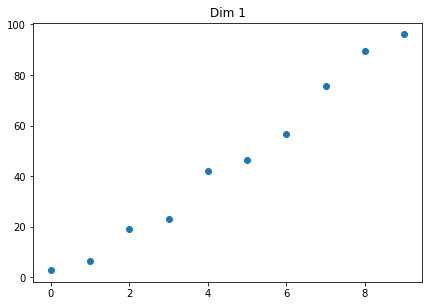

In [3]:
lm.plot_obs()

In [4]:
start = (lambda ys:[10*ys[0][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,mean_grad]

<a id="linear-rejection"></a>

In [5]:
%%time
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":3500,"sample_size":350}
error=ABC_Cross_Validation.LOO_CV_abc_rejection(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

1/10. Predicted - [13.423990460735741]. Actual - [6.582033773389246]. Error - 6.842
2/10. Predicted - [24.282673109287565]. Actual - [19.352977309887507]. Error - 4.930
3/10. Predicted - [34.592084021505826]. Actual - [23.073409099211318]. Error - 11.519
4/10. Predicted - [45.729993296872834]. Actual - [42.002592041406075]. Error - 3.727
5/10. Predicted - [56.346769149863285]. Actual - [46.240787044118285]. Error - 10.106
6/10. Predicted - [67.03125111616018]. Actual - [56.52241872907294]. Error - 10.509
7/10. Predicted - [76.13188594378798]. Actual - [75.75469430652853]. Error - 0.377
8/10. Predicted - [88.72039059905147]. Actual - [89.52725765204846]. Error - 0.807
9/10. Predicted - [100.45481943057402]. Actual - [96.057868970883]. Error - 4.397
Total error : 53.214
Wall time: 3min 29s


<a id="linear-mcmc"></a>

In [6]:
%%time
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x+stats.norm(0,.5).rvs(1)[0]]*2

error=ABC_Cross_Validation.LOO_CV_abc_mcmc(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),
    fitting_model=lm.copy([1,1]),priors=lm_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.uniform_kernel,scaling_factor=4,chain_length=3500,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

1/10. (New=0.406)Predicted - [13.222305396616704]. Actual - [6.582033773389246]. Error - 6.640
2/10. (New=0.396)Predicted - [24.113430346773747]. Actual - [19.352977309887507]. Error - 4.760
3/10. (New=0.382)Predicted - [35.92309144137307]. Actual - [23.073409099211318]. Error - 12.850
4/10. (New=0.397)Predicted - [45.361551202271]. Actual - [42.002592041406075]. Error - 3.359
5/10. (New=0.395)Predicted - [55.531969630622925]. Actual - [46.240787044118285]. Error - 9.291
6/10. (New=0.394)Predicted - [67.05826965491384]. Actual - [56.52241872907294]. Error - 10.536
7/10. (New=0.378)Predicted - [77.30291319344317]. Actual - [75.75469430652853]. Error - 1.548
8/10. (New=0.399)Predicted - [86.00448200744677]. Actual - [89.52725765204846]. Error - 3.523
9/10. (New=0.397)Predicted - [101.6202730505271]. Actual - [96.057868970883]. Error - 5.562
Total error : 58.070
Wall time: 4min 26s


<a id="linear-smc"></a>

In [7]:
%%time
np.random.seed(16111998) # Fix random seed
scaling_factors=list(np.linspace(10,6,5))

perturbance_variance=.1

perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

error=ABC_Cross_Validation.LOO_CV_abc_smc(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,
        perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
        num_steps=5,sample_size=50,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

1/10. 



Predicted - [12.243541093327803]. Actual - [6.582033773389246]. Error - 5.662
2/10. 



Predicted - [22.048823777870187]. Actual - [19.352977309887507]. Error - 2.696
3/10. 



Predicted - [32.616367597943984]. Actual - [23.073409099211318]. Error - 9.543
4/10. 



Predicted - [42.03262268747157]. Actual - [42.002592041406075]. Error - 0.030
5/10. 



Predicted - [52.73535491004395]. Actual - [46.240787044118285]. Error - 6.495
6/10. 



Predicted - [62.73720625507673]. Actual - [56.52241872907294]. Error - 6.215
7/10. 



Predicted - [71.39323813940052]. Actual - [75.75469430652853]. Error - 4.361
8/10. 



Predicted - [80.1853132395735]. Actual - [89.52725765204846]. Error - 9.342
9/10. 



Predicted - [92.4948484808358]. Actual - [96.057868970883]. Error - 3.563
Total error : 47.906
Wall time: 6min 9s


<a id="linear-adaptive-smc"></a>

In [8]:
%%time
np.random.seed(16111998) # Fix random seed

error=ABC_Cross_Validation.LOO_CV_adaptive_abc_smc(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,
        alpha=.9,max_steps=1000,max_simulations=4500,sample_size=100,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

1/10. **********************************Predicted - [10.784574147478379]. Actual - [6.582033773389246]. Error - 4.203
2/10. **********************************Predicted - [21.19614680458081]. Actual - [19.352977309887507]. Error - 1.843
3/10. ***********************************Predicted - [31.77285141501013]. Actual - [23.073409099211318]. Error - 8.699
4/10. ***********************************Predicted - [41.802577334860246]. Actual - [42.002592041406075]. Error - 0.200
5/10. *********************************Predicted - [53.044027965157326]. Actual - [46.240787044118285]. Error - 6.803
6/10. *********************************Predicted - [63.3300092942406]. Actual - [56.52241872907294]. Error - 6.808
7/10. ***********************************Predicted - [72.37287916876761]. Actual - [75.75469430652853]. Error - 3.382
8/10. **********************************Predicted - [81.66684425851416]. Actual - [89.52725765204846]. Error - 7.860
9/10. **********************************Predicted - [92.8

## Exponential Model

In [9]:
# Specify the model
np.random.seed(16111998) # Fix random seed
em=ExponentialModel(
    params=[2,.3],
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=.1,
)

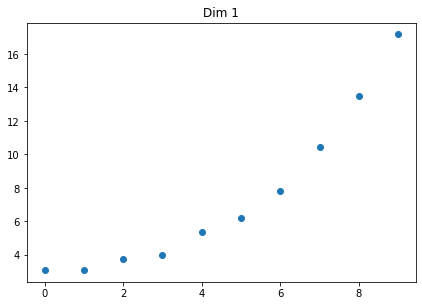

In [10]:
# Plot the observations
em.plot_obs()

In [11]:
em_priors=[stats.uniform(0,3),stats.uniform(0,1)]

In [12]:
# Define summary statistics
start = (lambda ys:[ys[0][0]])
mean_log_grad = (lambda ys:[10*np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,mean_log_grad]

<a id="exponential-rejection"></a>

In [13]:
%%time
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":3500,"sample_size":350}
error=ABC_Cross_Validation.LOO_CV_abc_rejection(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

0/10. Predicted - [2.55603604]. Actual - [3.11258724]. Error - 0.557
1/10. Predicted - [3.02092325]. Actual - [3.09478741]. Error - 0.074
2/10. Predicted - [3.43942115]. Actual - [3.7270279]. Error - 0.288
3/10. Predicted - [4.10763407]. Actual - [4.00196117]. Error - 0.106
4/10. Predicted - [5.09811393]. Actual - [5.3780016]. Error - 0.280
5/10. Predicted - [6.3280892]. Actual - [6.20691578]. Error - 0.121
6/10. Predicted - [7.69860845]. Actual - [7.79113419]. Error - 0.093
7/10. Predicted - [10.05630072]. Actual - [10.44068232]. Error - 0.384
8/10. Predicted - [12.87345332]. Actual - [13.51549783]. Error - 0.642
9/10. Predicted - [17.67183997]. Actual - [17.17174793]. Error - 0.500
Total error : 3.044
Wall time: 3min 55s


<a id="exponential-mcmc"></a>

In [14]:
%%time
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

error=ABC_Cross_Validation.LOO_CV_abc_mcmc(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),
    fitting_model=em.copy([1,1]),priors=em_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factor=2,chain_length=3500,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

0/10. (New=0.212)Predicted - [2.38283625]. Actual - [3.11258724]. Error - 0.730
1/10. (New=0.211)Predicted - [2.90511616]. Actual - [3.09478741]. Error - 0.190
2/10. (New=0.226)Predicted - [3.8986815]. Actual - [3.7270279]. Error - 0.172
3/10. (New=0.196)Predicted - [3.77494031]. Actual - [4.00196117]. Error - 0.227
4/10. (New=0.231)Predicted - [5.07306972]. Actual - [5.3780016]. Error - 0.305
5/10. (New=0.216)Predicted - [5.74064636]. Actual - [6.20691578]. Error - 0.466
6/10. (New=0.190)Predicted - [7.00951278]. Actual - [7.79113419]. Error - 0.782
7/10. (New=0.295)Predicted - [9.77214802]. Actual - [10.44068232]. Error - 0.669
8/10. (New=0.305)Predicted - [12.21736278]. Actual - [13.51549783]. Error - 1.298
9/10. (New=0.321)Predicted - [13.58196303]. Actual - [17.17174793]. Error - 3.590
Total error : 8.427
Wall time: 5min 11s


<a id="exponential-smc"></a>

In [15]:
%%time
np.random.seed(16111998) # Fix random seed
scaling_factors=list(np.linspace(4,1,3))

perturbance_variance=.1

perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

error=ABC_Cross_Validation.LOO_CV_abc_smc(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,
        perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
        num_steps=3,sample_size=50,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

0/10. 

Predicted - [2.75475017]. Actual - [3.11258724]. Error - 0.358
1/10. 

Predicted - [3.21707365]. Actual - [3.09478741]. Error - 0.122
2/10. 

Predicted - [3.65363409]. Actual - [3.7270279]. Error - 0.073
3/10. 

Predicted - [4.5294411]. Actual - [4.00196117]. Error - 0.527
4/10. 

Predicted - [5.29374553]. Actual - [5.3780016]. Error - 0.084
5/10. 

Predicted - [6.41946722]. Actual - [6.20691578]. Error - 0.213
6/10. 

Predicted - [8.03263118]. Actual - [7.79113419]. Error - 0.241
7/10. 

Predicted - [10.14444268]. Actual - [10.44068232]. Error - 0.296
8/10. 

Predicted - [13.1945874]. Actual - [13.51549783]. Error - 0.321
9/10. 

Predicted - [17.43231784]. Actual - [17.17174793]. Error - 0.261
Total error : 2.497
Wall time: 6min 44s


<a id="exponential-adaptive-smc"></a>

In [16]:
%%time
np.random.seed(16111998) # Fix random seed

error=ABC_Cross_Validation.LOO_CV_adaptive_abc_smc(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,
        alpha=.9,max_steps=1000,max_simulations=4000,sample_size=100,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

0/10. ************************************Predicted - [2.95049935]. Actual - [3.11258724]. Error - 0.162
1/10. ************************************Predicted - [2.0627937]. Actual - [3.09478741]. Error - 1.032
2/10. ************************************Predicted - [2.93992192]. Actual - [3.7270279]. Error - 0.787
3/10. ************************************Predicted - [3.81989406]. Actual - [4.00196117]. Error - 0.182
4/10. ************************************Predicted - [3.92694013]. Actual - [5.3780016]. Error - 1.451
5/10. ************************************Predicted - [5.61339211]. Actual - [6.20691578]. Error - 0.594
6/10. ************************************Predicted - [7.99766371]. Actual - [7.79113419]. Error - 0.207
7/10. ************************************Predicted - [10.48394444]. Actual - [10.44068232]. Error - 0.043
8/10. ************************************Predicted - [13.04204994]. Actual - [13.51549783]. Error - 0.473
9/10. ************************************Predicted - 

## SIR Model

In [2]:
sir_model=SIRModel(
    params=[100000,100,1,.5],
    n_obs=30,
    x_obs=[[x] for x in range(30)],)
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
sir_smc_priors=[stats.uniform(100000,1),stats.uniform(100,1),stats.uniform(0,1.5),stats.uniform(0,2)]

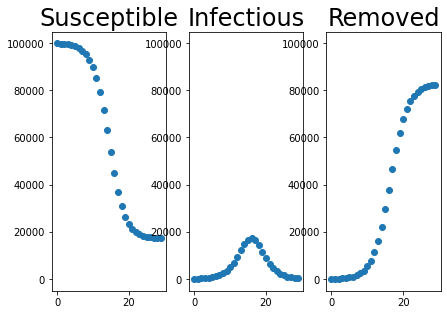

In [3]:
sir_model.plot_obs(constant_scale=True)

<a id="sir-rejection"></a>

In [5]:
%%time
# ABC Rejection
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":10000,"sample_size":1000,"distance_measure":ABC.log_l2_norm}
error=ABC_Cross_Validation.LOO_CV_abc_rejection(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,sampling_details=sampling_details)
print("Total error : {:,.3f}".format(error))

0/30. Predicted - (99900.0, 100.0, 0). Actual - (99900, 100, 0). Error - 0.000
1/30. Predicted - (99790.0, 156.0, 54). Actual - (99801, 149, 50). Error - 13.638
2/30. Predicted - (99622.0, 240.0, 138). Actual - (99653, 223, 124). Error - 38.026
3/30. Predicted - (99356.0, 379.0, 265). Actual - (99431, 334, 235). Error - 92.466
4/30. Predicted - (98952.0, 579.0, 469). Actual - (99099, 499, 402). Error - 180.272
5/30. Predicted - (98334.0, 882.0, 784). Actual - (98605, 744, 651). Error - 331.925
6/30. Predicted - (97329.0, 1383.0, 1288). Actual - (97872, 1105, 1023). Error - 665.100
7/30. Predicted - (95967.0, 2010.0, 2023). Actual - (96791, 1634, 1575). Error - 1010.473
8/30. Predicted - (93673.0, 3102.0, 3225). Actual - (95210, 2398, 2392). Error - 1884.642
9/30. Predicted - (90228.0, 4775.0, 4997). Actual - (92927, 3482, 3591). Error - 3306.552
10/30. Predicted - (85583.0, 6857.0, 7560). Actual - (89692, 4976, 5332). Error - 5038.455
11/30. Predicted - (78039.0, 10350.0, 11611). Actua

<a id="sir-mcmc"></a>

In [9]:
%%time
# ABC MCMC
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

error=ABC_Cross_Validation.LOO_CV_abc_mcmc(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),
    fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factor=1/3,chain_length=10000,
    distance_measure=ABC.log_l2_norm)
print("Total error : {:,.3f}".format(error))

0/30. (New=0.278)Predicted - (99900.0, 100.0, 0). Actual - (99900, 100, 0). Error - 0.000
1/30. (New=0.254)Predicted - (99794.0, 153.0, 53). Actual - (99801, 149, 50). Error - 8.602
2/30. (New=0.272)Predicted - (99637.0, 234.0, 129). Actual - (99653, 223, 124). Error - 20.050
3/30. (New=0.256)Predicted - (99381.0, 362.0, 257). Actual - (99431, 334, 235). Error - 61.384
4/30. (New=0.268)Predicted - (99015.0, 516.0, 469). Actual - (99099, 499, 402). Error - 108.784
5/30. (New=0.259)Predicted - (98442.0, 804.0, 754). Actual - (98605, 744, 651). Error - 201.936
6/30. (New=0.268)Predicted - (97634.0, 1206.0, 1160). Actual - (97872, 1105, 1023). Error - 292.599
7/30. (New=0.267)Predicted - (96425.0, 1773.0, 1802). Actual - (96791, 1634, 1575). Error - 452.555
8/30. (New=0.264)Predicted - (94536.0, 2695.0, 2769). Actual - (95210, 2398, 2392). Error - 827.414
9/30. (New=0.270)Predicted - (92091.0, 3759.0, 4150). Actual - (92927, 3482, 3591). Error - 1043.123
10/30. (New=0.265)Predicted - (8774

<a id="sir-smc"></a>

In [5]:
%%time
# ABC SMC (Non-Adaptive)
np.random.seed(16111998) # Fix random seed
perturbance_variance=.1
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:1]*2 + [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]*2

scaling_factors=list(np.logspace(-1,-.05,13,base=10))

error=ABC_Cross_Validation.LOO_CV_abc_smc(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
        perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
        num_steps=13,sample_size=50,distance_measure=ABC.log_l2_norm)

print("Total error : {:,.3f}".format(error))

0/30. ************Predicted - (99899.99911001843, 100.58549321192548, 0). Actual - (99900, 100, 0). Error - 0.585
1/30. ************Predicted - (99802.40824208948, 150.1206183727562, 48). Actual - (99801, 149, 50). Error - 2.691
2/30. ************Predicted - (99650.63720356041, 224.57914514233653, 125). Actual - (99653, 223, 124). Error - 3.013
3/30. ************Predicted - (99416.07467771533, 330.49663003490184, 254). Actual - (99431, 334, 235). Error - 24.414
4/30. ************Predicted - (99076.96303783433, 510.57229195901715, 413). Actual - (99099, 499, 402). Error - 27.213
5/30. ************Predicted - (98594.82420021857, 745.6944503085089, 660). Actual - (98605, 744, 651). Error - 13.690
6/30. ************Predicted - (97822.18923934591, 1145.2492890132103, 1033). Actual - (97872, 1105, 1023). Error - 64.816
7/30. ************Predicted - (96769.90774357943, 1648.541315858466, 1582). Actual - (96791, 1634, 1575). Error - 26.558
8/30. ************Predicted - (95110.83359259588, 2460

<a id="sir-adaptive-smc"></a>

In [4]:
%%time
#ABC SMC (Adapative Purturbance)
np.random.seed(16111998) # Fix random seed

scaling_factors=list(np.logspace(-1,-.05,13,base=10))

error=ABC_Cross_Validation.LOO_CV_adaptive_perturbance_abc_smc(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
        acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,distance_measure=ABC.log_l2_norm,
        num_steps=13,sample_size=50)
print("Total error : {:,.3f}".format(error))

0/30. ************Predicted - (99900.07181869268, 100.48994367074523, 0). Actual - (99900, 100, 0). Error - 0.495
1/30. ************Predicted - (99800.92471891886, 150.6537531413332, 49). Actual - (99801, 149, 50). Error - 1.934
2/30. ************Predicted - (99647.8726962585, 224.62705937263388, 128). Actual - (99653, 223, 124). Error - 6.703
3/30. ************Predicted - (99422.12702407122, 341.29903005248235, 237). Actual - (99431, 334, 235). Error - 11.662
4/30. ************Predicted - (99082.1234388135, 501.494385754603, 417). Actual - (99099, 499, 402). Error - 22.717
5/30. ************Predicted - (98596.37682768638, 749.3230792253015, 655). Actual - (98605, 744, 651). Error - 10.895
6/30. ************Predicted - (97849.0555298643, 1118.456243315079, 1033). Actual - (97872, 1105, 1023). Error - 28.417
7/30. ************Predicted - (96789.04159222162, 1634.6617391843874, 1577). Actual - (96791, 1634, 1575). Error - 2.876
8/30. ************Predicted - (95127.23793153168, 2425.41910

In [8]:
%%time
#ABC SMC (Adapative Purturbance & Acceptance)
np.random.seed(16111998) # Fix random seed
error=ABC_Cross_Validation.LOO_CV_adaptive_abc_smc(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
        alpha=.9,max_steps=100,max_simulations=3500,sample_size=50,terminal_scaling_factor=10**(-.05),
        distance_measure=ABC.log_l2_norm)
print("Total error : {:,.3f}".format(error))

0/30. **************************************************Predicted - (99899.71378344546, 100.55352123452798, 0). Actual - (99900, 100, 0). Error - 0.623
1/30. ***********************************************Predicted - (99800.35018916574, 150.28835408300415, 50). Actual - (99801, 149, 50). Error - 1.443
2/30. ****************************************************Predicted - (99649.85963041616, 225.473376344806, 125). Actual - (99653, 223, 124). Error - 4.121
3/30. ***********************************************Predicted - (99425.22097939914, 339.4541490255599, 236). Actual - (99431, 334, 235). Error - 8.009
4/30. ***********************************************Predicted - (99085.14953258699, 500.3634592398599, 415). Actual - (99099, 499, 402). Error - 19.045
5/30. **************************************************Predicted - (98606.20621760079, 735.5380113879111, 659). Actual - (98605, 744, 651). Error - 11.707
6/30. *************************************************Predicted - (97866.704864

# Summary Statistic Selection Methods

## Semi-Automatic ABC

*ABC-Rejection \w Semi-Auto Summary Statistic Selection*

In [ ]:
%%time
# Linear Model - ABC Rejection - Semi-Auto
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":1500,"sample_size":150}
error=ABC_Cross_Validation.LOO_CV_abc_rejection_semi_auto(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100,summary_stats=None)
print("Total error : {:,.3f}".format(error))

In [ ]:
%%time
# Exponential Model - ABC Rejection - Semi-Auto
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":1500,"sample_size":150}
error=ABC_Cross_Validation.LOO_CV_abc_rejection_semi_auto(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,sampling_details=sampling_details,pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100,summary_stats=None)
print("Total error : {:,.3f}".format(error))

In [ ]:
%%time
# SIR Model - ABC Rejection - Semi-Auto
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":1500,"sample_size":150,"distance_measure":ABC.log_l2_norm}
error=ABC_Cross_Validation.LOO_CV_abc_rejection_semi_auto(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,sampling_details=sampling_details,pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100,summary_stats=None)
print("Total error : {:,.3f}".format(error))

*ABC-MCMC \w Semi-Auto Summary statistic selection*

In [ ]:
%%time
# Linear Model - ABC MCMC - Semi-Auto
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2
error=ABC_Cross_Validation.LOO_CV_abc_mcmc_semi_auto(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),
    fitting_model=lm.copy([1,1]),priors=lm_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factor=12,chain_length=1500,
    pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100)

print("Total error : {:,.3f}".format(error))

In [ ]:
%%time
# SIR Model - ABC MCMC - Semi-Auto
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2
error=ABC_Cross_Validation.LOO_CV_abc_mcmc_semi_auto(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),
    fitting_model=em.copy([1,1]),priors=em_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factor=7,chain_length=1500,
    pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100)
print("Total error : {:,.3f}".format(error))

In [ ]:
%%time
# SIR Model - ABC MCMC - Semi-Auto
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2
error=ABC_Cross_Validation.LOO_CV_abc_mcmc_semi_auto(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),
    fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factor=100000,chain_length=1500,
    pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100)
print("Total error : {:,.3f}".format(error))

*ABC-SMC \w Semi-Auto Summary statistic selection*

In [ ]:
%%time
# Linear Model - ABC SMC - Semi-Auto
np.random.seed(16111998) # Fix random seed

perturbance_variance=.1

perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

scaling_factors=list(np.linspace(15,6,4))

error=ABC_Cross_Validation.LOO_CV_abc_smc_semi_auto(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),
    fitting_model=lm.copy([1,1]),priors=lm_priors,perturbance_kernels=perturbance_kernels,
    num_steps=4,sample_size=50,perturbance_kernel_probability=perturbance_kernel_probability,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
    pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100)
print("Total error : {:,.3f}".format(error))

In [ ]:
%%time
# Exponential Model - ABC SMC - Semi-Auto
np.random.seed(16111998) # Fix random seed

perturbance_variance=.1
perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

scaling_factors=list(np.linspace(10,1,4))

error=ABC_Cross_Validation.LOO_CV_abc_smc_semi_auto(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),
    fitting_model=em.copy([1,1]),priors=em_priors,perturbance_kernels=perturbance_kernels,
    num_steps=4,sample_size=50,perturbance_kernel_probability=perturbance_kernel_probability,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
    pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100)
print("Total error : {:,.3f}".format(error))

In [ ]:
%%time
# SIR Model - ABC SMC - Semi-Auto
np.random.seed(16111998) # Fix random seed

perturbance_variance=.1
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:1]*2 + [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]*2

scaling_factors=list(np.linspace(100000,25000,4))

error=ABC_Cross_Validation.LOO_CV_abc_smc_semi_auto(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),
    fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,perturbance_kernels=perturbance_kernels,
    num_steps=4,sample_size=50,perturbance_kernel_probability=perturbance_kernel_probability,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
    pilot_distance_measure=ABC.l2_norm,n_pilot_samples=2000,n_pilot_acc=400,n_params_sample_size=100)
print("Total error : {:,.3f}".format(error))

In [4]:
%%time
#TODO
sir_smc_priors=[stats.uniform(100000,1),stats.uniform(100,1),stats.uniform(.5,1.5),stats.uniform(0,.8)]
error=ABC_Cross_Validation.LOO_CV_abc_adaptive_smc_semi_auto(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),
                                  fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
                                  sample_size=50,max_steps=100,max_simulations=10000,alpha=.9,
                                  distance_measure=ABC.log_l2_norm,n_pilot_samples=50000,terminal_scaling_factor=10**(-5),
                                  n_pilot_acc=5000,n_params_sample_size=500)
print("Total error : {:,.3f}".format(error))

0/30. ******************************************************************** Predicted - (99900.17492804976, 100.21595345813336, 0). Actual - (99900, 100, 0). Error - 0.278
1/30. ****** Predicted - (99758.06322168747, 211.5293037863293, 31). Actual - (99801, 149, 50). Error - 78.195
2/30. **** Predicted - (99502.03619693968, 389.4770067030799, 109). Actual - (99653, 223, 124). Error - 225.232
3/30. ***** Predicted - (99327.02447500617, 428.5952535611708, 245). Actual - (99431, 334, 235). Error - 140.923
4/30. ***** Predicted - (98909.97391532762, 682.5502824227601, 408). Actual - (99099, 499, 402). Error - 263.548
5/30. ******* Predicted - (98052.15499812263, 1149.4514234548888, 799). Actual - (98605, 744, 651). Error - 701.379
6/30. **** Predicted - (95615.02371068917, 2804.523649201209, 1581). Actual - (97872, 1105, 1023). Error - 2879.876
7/30. **** Predicted - (90106.99127944763, 6846.591095771375, 3047). Actual - (96791, 1634, 1575). Error - 8603.131
8/30. **** Predicted - (74278.01

# Results

| Method \ Model |  Linear | Exponential | SIR |
|----------------|---------|-------------|-----|
| ABC-Rejection Sampling | 53 | 3 | 137,806 |
| ABC-MCMC | 58 | 8 | 120,610 |
| ABC-SMC | 48 | 2 | 82,413 |

There is no significant difference in the performance of the different algorithms for the linear model. This is not unsurprising as this is a very simple model and there are better (non-ABC methods) for fitting a linear model.

For the exponential model there is a notable improvement in performance when using ABC-MCMC or ABC-SMC over ABC-Rejection Sampling. Likely due to the fact that a small change in the exponent parameter of an exponential model has a greater affect than an equivalent change to the multiplicative factor in a linear model. Thus once a good value is found, it is better to fine-tune that value (as in ABC-MCMC & ABC-SMC) rather than to start another independent search (ABC-Rejection).

The results for the SIR model show significant differences between each algorithm, with the ABC-SMC algorithm performing best of all.

Naturally, these results are all highly dependent on how the algorithms are implemented and tuned. I set up the algorithms so that they all used ~3,5000 simulations (because time); ABC-rejection used the 10% best; ABC-MCMC accepts ~30% of simulations; and SMC has 5/6 steps.

| Method \ Model |  Linear | Exponential | SIR |
|----------------|---------|-------------|-----|
| ABC-Rejection \w Semi-Auto | 47 | 45 | 580,406 |
| ABC-MCMC \w Semi-Auto | 52 | 15 | 395,747 |
| ABC-SMC \w Semi-Auto | 47 | 2.5 | 155,680 |